In [70]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append("../")
from src import soporte_eda as s_eda

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="victor_fdz")

pd.options.display.max_columns
pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_columns', 1000)
import warnings
warnings.filterwarnings("ignore")

In [71]:
df = pd.read_csv("../Datos/api_rent_madrid.csv", sep = ";")

Nuestra variable respuesta será el "price", y en torno a ella estableceremos todo nuestro análisis.

In [72]:
print(df.shape)
df.columns

(450, 38)


Index(['propertyCode', 'numPhotos', 'price', 'propertyType', 'operation',
       'size', 'exterior', 'rooms', 'bathrooms', 'address', 'province',
       'municipality', 'country', 'latitude', 'longitude', 'showAddress',
       'distance', 'description', 'hasVideo', 'status', 'newDevelopment',
       'priceByArea', 'detailedType', 'suggestedTexts', 'hasPlan', 'has3DTour',
       'has360', 'hasStaging', 'superTopHighlight', 'topNewDevelopment',
       'externalReference', 'floor', 'district', 'neighborhood', 'hasLift',
       'parkingSpace', 'labels', 'newDevelopmentFinished'],
      dtype='object')

- Encontramos que hay 8 duplicados. Existen nuelos en todas las columnas. 
- Especialmente destacan newDevelopmentFinished y labels. parkingSpace y neighborhood También tienen una cantidad significativa de nulos. 
- Hay muchas columnas categóricas con formatos un tanto extraños. 
- Hay muchos valores repetidos en latitud y longitud. DETAILEDTYPE es un diccionario. 
- Habría que normalizarla. La columna EXTERNALREFERENCE no tiene interpretación. La eliminaremos. 
- La columna Floor tiene un mix entre numeros y strings, Hay que sustituir "bj" por 0. 
- Hay que complementar la columna Neigborhood con DISTRICT y MUNICIPALITY.
- La columna PARKINGSPACE es un diccionario que hay que extender.

In [73]:
# s_eda.exploracion_dataframe(df,"price")

Comenzamos con los duplicados. Efectivamente hemos eliminado los 8

In [74]:
df.drop_duplicates(inplace= True)
df.shape

(442, 38)

Vamos a por los nulos, Empecemos con las categóricas:

In [75]:
df_num,df_cat = s_eda.separar_categorias(df)
gestionar_nulos_categoricas =s_eda.GestionNulos(df_cat)

In [76]:
nulos = gestionar_nulos_categoricas.calcular_porcentaje_nulos()
nulos

description                0.226244
hasVideo                   4.072398
status                     4.072398
newDevelopment             4.072398
detailedType               4.072398
suggestedTexts             4.072398
hasPlan                    4.072398
has3DTour                  4.072398
has360                     4.072398
hasStaging                 4.072398
superTopHighlight          4.072398
topNewDevelopment          4.072398
externalReference         23.529412
floor                     18.325792
district                  24.660633
neighborhood              60.633484
hasLift                    7.013575
parkingSpace              69.683258
labels                    93.212670
newDevelopmentFinished    97.058824
dtype: float64

In [77]:
# #Finalmente rellenamos el resto de los nulos con "Unknown"
df[df_cat.columns] = df[df_cat.columns].fillna("Unknown")

#Como la columna "PropertyType" está completa y no tiene nulos, podemos eliminar "labels" que tiene muchos nulos y sólo aporta información de muy pocos apartamentos
df["propertyType"].info()
df.drop(columns = ["labels"], inplace= True)

#La columna "newDevelopmentFinished" Tiene demasiados nulos como para imputarlos por un 'Unknown' o usar un knn. Como no aporta casi información, la eliminamos
df[df["newDevelopmentFinished"] == True]
df.drop(columns = ["newDevelopmentFinished"], inplace= True)

print(df["floor"].unique())
#Vamos a por floor, vemos que "en" no significa nada, o al menos no se encuentra un patrón en las descripciones
df["floor"].replace("en","Unknown",inplace=True)
#Vemos que ss significa semisótano (ZULO). Lo reemplazamos por UNKNOWN al ser sólo un valor y no aportar información significativa a la escala
df[df["floor"] == "ss"]["description"]
df["floor"].replace("ss","Unknown",inplace=True)
#"st" no tiene un significado concreto, lo convertimos en Unknown
df[df["floor"] == "st"]["description"]
df["floor"].replace("st","Unknown",inplace=True)
#Entendemos que bj sigifica bajo, comprobamos:
df[df["floor"] == "bj"]["description"]
df["floor"].replace("bj","0",inplace=True)
#por último revisamos el piso 14, que es un poco extraño. La descripción no indica nada, pero como es un valor muy alto lo calificamos de unknown para que no nos fastidie la escala
df["floor"].replace("14","Unknown",inplace=True)
#Finalmente pasamos los nans a unknown
df["floor"].fillna("Unknown", inplace = True)

#Eliminamos externalReference por no tener sentido
df["externalReference"].unique()
df.drop(columns = "externalReference",inplace = True)


<class 'pandas.core.series.Series'>
Index: 442 entries, 0 to 449
Series name: propertyType
Non-Null Count  Dtype 
--------------  ----- 
442 non-null    object
dtypes: object(1)
memory usage: 6.9+ KB
['Unknown' '3' 'bj' '2' '1' '5' 'en' '4' 'st' '8' '7' '6' '14' 'ss']


In [78]:
df_localizado = df.copy()

Hemos cogido unas coordenadas al azar y vemos que el problema de las coordenadas está en el punto. vamos a arreglarlo:

In [79]:
df_localizado["latitude"] = df_localizado["latitude"].str.replace(".", "")
df_localizado["latitude"] = df_localizado["latitude"].apply(lambda x: x[:2] + "." + x[2:])

df_localizado["longitude"] = df_localizado["longitude"].str.replace(".", "")
df_localizado["longitude"] = df_localizado["longitude"].apply(lambda x: x[:2] + "." + x[2:])


In [80]:
geolocator = Nominatim(user_agent="victor_fdz")
location = geolocator.geocode("Calle de Alejandro Villegas, 23	Madrid	")
print(location.address)

print((location.latitude, location.longitude))

print(location.raw)


Calle de Alejandro Villegas, Canillas, Hortaleza, Madrid, Comunidad de Madrid, 28043, España
(40.465009820146534, -3.648843611587462)
{'place_id': 271216843, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 23377491, 'lat': '40.465009820146534', 'lon': '-3.648843611587462', 'class': 'highway', 'type': 'residential', 'place_rank': 26, 'importance': 0.053419141680018274, 'addresstype': 'road', 'name': 'Calle de Alejandro Villegas', 'display_name': 'Calle de Alejandro Villegas, Canillas, Hortaleza, Madrid, Comunidad de Madrid, 28043, España', 'boundingbox': ['40.4630290', '40.4669932', '-3.6491869', '-3.6484860']}


Ahora obtenemos todos los detalles posibles desde geopy para asegurarnos de que la información es correcta

In [81]:
from geopy.geocoders import Nominatim

# Crear geolocador
geolocator = Nominatim(user_agent="victor_fdz")

# Función para realizar reverse geocoding y obtener todos los detalles como un diccionario
def get_full_address(lat, lon):
    
    try:
        # Realizar reverse geocoding y obtener la información detallada
        location = geolocator.reverse((lat, lon), language='es', addressdetails=True)
        
        # Si la ubicación es válida, devolver el diccionario completo de la dirección
        if location and 'address' in location.raw:
            return location.raw['address']
        return None
    except Exception as e:
        print(f"Error al geolocalizar ({lat}, {lon}): {e}")
        return None

df_localizado['detalles'] = df_localizado.apply(lambda row: get_full_address(row['latitude'], row['longitude']), axis=1)

In [82]:
df_localizado

,propertyCode,numPhotos,price,propertyType,operation,size,exterior,rooms,bathrooms,address,...,has360,hasStaging,superTopHighlight,topNewDevelopment,floor,district,neighborhood,hasLift,parkingSpace,detalles
0,98903350,33,550.0,chalet,rent,371.0,False,6,3,Numancia de la Sagra,...,False,False,False,False,Unknown,Unknown,Unknown,Unknown,Unknown,"{'road': 'Calle de los Olmos', 'hamlet': 'El Pinar de Villeriche', 'village': 'Numancia de la Sagra', 'province': 'Toledo', 'ISO3166-2-lvl6': 'ES-TO', 'state': 'Castilla-La Mancha', 'ISO3166-2-lvl4': 'ES-CM', 'postcode': '45290', 'country': 'España', 'country_code': 'es'}"
1,91615378,12,750.0,flat,rent,60.0,True,1,1,"Calle de Alejandro Villegas, 23",...,False,False,False,False,3,Hortaleza,Canillas,True,Unknown,"{'house_number': '29', 'road': 'Calle de Alejandro Villegas', 'quarter': 'Canillas', 'suburb': 'Hortaleza', 'city': 'Madrid', 'state': 'Comunidad de Madrid', 'ISO3166-2-lvl4': 'ES-MD', 'postcode': '28043', 'country': 'España', 'country_code': 'es'}"
2,88363329,21,750.0,flat,rent,70.0,True,2,1,Gregorio izquierdo,...,False,False,False,False,0,Centro Urbano,Unknown,False,Unknown,"{'road': 'Calle Cardenal Carranza', 'town': 'San Sebastián de los Reyes', 'state': 'Comunidad de Madrid', 'ISO3166-2-lvl4': 'ES-MD', 'postcode': '28700', 'country': 'España', 'country_code': 'es'}"
3,98621753,28,400.0,penthouse,rent,67.0,True,2,2,Calle Madrid,...,True,False,False,False,2,Unknown,Unknown,False,Unknown,"{'road': 'Calle Cuevas del Norte', 'village': 'Villamanrique de Tajo', 'state': 'Comunidad de Madrid', 'ISO3166-2-lvl4': 'ES-MD', 'postcode': '28598', 'country': 'España', 'country_code': 'es'}"
4,98222714,22,450.0,flat,rent,89.0,False,2,1,Calle Arroyo,...,False,False,False,False,2,Unknown,Unknown,True,"{'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice': True}","{'road': 'Calle del Sol', 'village': 'Recas', 'province': 'Toledo', 'ISO3166-2-lvl6': 'ES-TO', 'state': 'Castilla-La Mancha', 'ISO3166-2-lvl4': 'ES-CM', 'postcode': '45211', 'country': 'España', 'country_code': 'es'}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,98815692,16,640.0,flat,rent,69.0,True,2,1,"Calle Gonzalo de Berceo, 16",...,False,False,False,False,2,Unknown,Unknown,True,"{'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice': True}","{'road': 'Calle de Gonzalo de Berceo', 'suburb': 'Urbanización El Viso', 'village': 'Los Hueros', 'town': 'Villalbilla', 'state': 'Comunidad de Madrid', 'ISO3166-2-lvl4': 'ES-MD', 'postcode': '28810', 'country': 'España', 'country_code': 'es'}"
446,97765107,19,700.0,flat,rent,54.0,True,1,1,Calle Núñez de Balboa,...,True,False,False,False,1,Getafe Centro,Unknown,True,Unknown,"{'amenity': 'Comisaría Policía Nacional de Getafe', 'road': 'Calle Churruca', 'suburb': 'Centro', 'city_district': 'Centro', 'city': 'Getafe', 'state': 'Comunidad de Madrid', 'ISO3166-2-lvl4': 'ES-MD', 'postcode': '28902', 'country': 'España', 'country_code': 'es'}"
447,98620594,16,700.0,flat,rent,59.0,True,1,1,"Calle de las Trompas, 40",...,False,False,False,False,6,Carabanchel,Pau de Carabanchel,True,"{'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice': True}","{'road': 'Calle de las Trompas', 'quarter': 'Cuatro Vientos', 'suburb': 'Latina', 'city': 'Madrid', 'state': 'Comunidad de Madrid', 'ISO3166-2-lvl4': 'ES-MD', 'postcode': '28054', 'country': 'España', 'country_code': 'es'}"
448,98791417,11,700.0,flat,rent,75.0,True,2,1,"Calle Alonso Sánchez, 6",...,False,False,False,False,1,Pryconsa - Poligono Europa,Unknown,False,Unknown,"{'road': 'Calle Alonso Sánchez', 'neighbourhood': 'Urbanización Santos Niños', 'suburb': 'Virgen del Val', 'city_district': 'Distrito V', 'city': 'Alcalá de Henares', 'state': 'Comunidad de Madrid', 'ISO3166-2-lvl4': 'ES-MD', 'postcode': '28800', 'country': 'España', 'country_code': 'es'}"


In [83]:
df_localizado['calle'] = df_localizado.apply(lambda row: s_eda.replace_calles(row["address"], row["detalles"]), axis=1)

df_localizado['barrio'] = df_localizado.apply(lambda row: s_eda.replace_barrios(row["neighborhood"], row['detalles']), axis=1)

df_localizado['distrito'] = df_localizado.apply(lambda row: s_eda.replace_distritos(row["district"], row['detalles']), axis=1)

In [84]:
df_localizado.drop(columns = ["address","neighborhood","district"], inplace= True)
df_localizado

,propertyCode,numPhotos,price,propertyType,operation,size,exterior,rooms,bathrooms,province,...,hasStaging,superTopHighlight,topNewDevelopment,floor,hasLift,parkingSpace,detalles,calle,barrio,distrito
0,98903350,33,550.0,chalet,rent,371.0,False,6,3,Toledo,...,False,False,False,Unknown,Unknown,Unknown,"{'road': 'Calle de los Olmos', 'hamlet': 'El Pinar de Villeriche', 'village': 'Numancia de la Sagra', 'province': 'Toledo', 'ISO3166-2-lvl6': 'ES-TO', 'state': 'Castilla-La Mancha', 'ISO3166-2-lvl4': 'ES-CM', 'postcode': '45290', 'country': 'España', 'country_code': 'es'}",Calle de los Olmos,Unknown,Unknown
1,91615378,12,750.0,flat,rent,60.0,True,1,1,Madrid,...,False,False,False,3,True,Unknown,"{'house_number': '29', 'road': 'Calle de Alejandro Villegas', 'quarter': 'Canillas', 'suburb': 'Hortaleza', 'city': 'Madrid', 'state': 'Comunidad de Madrid', 'ISO3166-2-lvl4': 'ES-MD', 'postcode': '28043', 'country': 'España', 'country_code': 'es'}","Calle de Alejandro Villegas, 23",Canillas,Hortaleza
2,88363329,21,750.0,flat,rent,70.0,True,2,1,Madrid,...,False,False,False,0,False,Unknown,"{'road': 'Calle Cardenal Carranza', 'town': 'San Sebastián de los Reyes', 'state': 'Comunidad de Madrid', 'ISO3166-2-lvl4': 'ES-MD', 'postcode': '28700', 'country': 'España', 'country_code': 'es'}",Calle Cardenal Carranza,Unknown,Centro Urbano
3,98621753,28,400.0,penthouse,rent,67.0,True,2,2,Madrid,...,False,False,False,2,False,Unknown,"{'road': 'Calle Cuevas del Norte', 'village': 'Villamanrique de Tajo', 'state': 'Comunidad de Madrid', 'ISO3166-2-lvl4': 'ES-MD', 'postcode': '28598', 'country': 'España', 'country_code': 'es'}",Calle Cuevas del Norte,Unknown,Unknown
4,98222714,22,450.0,flat,rent,89.0,False,2,1,Toledo,...,False,False,False,2,True,"{'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice': True}","{'road': 'Calle del Sol', 'village': 'Recas', 'province': 'Toledo', 'ISO3166-2-lvl6': 'ES-TO', 'state': 'Castilla-La Mancha', 'ISO3166-2-lvl4': 'ES-CM', 'postcode': '45211', 'country': 'España', 'country_code': 'es'}",Calle del Sol,Unknown,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,98815692,16,640.0,flat,rent,69.0,True,2,1,Madrid,...,False,False,False,2,True,"{'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice': True}","{'road': 'Calle de Gonzalo de Berceo', 'suburb': 'Urbanización El Viso', 'village': 'Los Hueros', 'town': 'Villalbilla', 'state': 'Comunidad de Madrid', 'ISO3166-2-lvl4': 'ES-MD', 'postcode': '28810', 'country': 'España', 'country_code': 'es'}",Calle de Gonzalo de Berceo,Unknown,Urbanización El Viso
446,97765107,19,700.0,flat,rent,54.0,True,1,1,Madrid,...,False,False,False,1,True,Unknown,"{'amenity': 'Comisaría Policía Nacional de Getafe', 'road': 'Calle Churruca', 'suburb': 'Centro', 'city_district': 'Centro', 'city': 'Getafe', 'state': 'Comunidad de Madrid', 'ISO3166-2-lvl4': 'ES-MD', 'postcode': '28902', 'country': 'España', 'country_code': 'es'}",Calle Churruca,Unknown,Getafe Centro
447,98620594,16,700.0,flat,rent,59.0,True,1,1,Madrid,...,False,False,False,6,True,"{'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice': True}","{'road': 'Calle de las Trompas', 'quarter': 'Cuatro Vientos', 'suburb': 'Latina', 'city': 'Madrid', 'state': 'Comunidad de Madrid', 'ISO3166-2-lvl4': 'ES-MD', 'postcode': '28054', 'country': 'España', 'country_code': 'es'}","Calle de las Trompas, 40",Cuatro Vientos,Latina
448,98791417,11,700.0,flat,rent,75.0,True,2,1,Madrid,...,False,False,False,1,False,Unknown,"{'road': 'Calle Alonso Sánchez', 'neighbourhood': 'Urbanización Santos Niños', 'suburb': 'Virgen del Val', 'city_district': 'Distrito V', 'city': 'Alcalá de Henares', 'state': 'Comunidad de Madrid', 'ISO3166-2-lvl4': 'ES-MD', 'postcode': '28800', 'country': 'España', 'country_code': 'es'}","Calle Alonso Sánchez, 6",Urbanización Santos Niños,Virgen del Val


In [85]:
# df_localizado.to_csv("../Datos/df_geopy.csv")

In [86]:
df["neigborhood"] = df_localizado["barrio"]
df["address"] = df_localizado["calle"]
df["district"] = df_localizado["distrito"]

In [87]:
(df["parkingSpace"].unique())
df[df["description"].str.contains("parking") == True]
df["parkingSpace"].fillna("Unknown", inplace= True)

#Por ahora la dropearemos hasta poder sacarlos precios correctamente
df.drop(columns=["parkingSpace"])


,propertyCode,numPhotos,price,propertyType,operation,size,exterior,rooms,bathrooms,address,...,has3DTour,has360,hasStaging,superTopHighlight,topNewDevelopment,floor,district,neighborhood,hasLift,neigborhood
0,98903350,33,550.0,chalet,rent,371.0,False,6,3,Calle de los Olmos,...,False,False,False,False,False,Unknown,Unknown,Unknown,Unknown,Unknown
1,91615378,12,750.0,flat,rent,60.0,True,1,1,"Calle de Alejandro Villegas, 23",...,False,False,False,False,False,3,Hortaleza,Canillas,True,Canillas
2,88363329,21,750.0,flat,rent,70.0,True,2,1,Calle Cardenal Carranza,...,False,False,False,False,False,0,Centro Urbano,Unknown,False,Unknown
3,98621753,28,400.0,penthouse,rent,67.0,True,2,2,Calle Cuevas del Norte,...,False,True,False,False,False,2,Unknown,Unknown,False,Unknown
4,98222714,22,450.0,flat,rent,89.0,False,2,1,Calle del Sol,...,False,False,False,False,False,2,Unknown,Unknown,True,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,98815692,16,640.0,flat,rent,69.0,True,2,1,Calle de Gonzalo de Berceo,...,False,False,False,False,False,2,Urbanización El Viso,Unknown,True,Unknown
446,97765107,19,700.0,flat,rent,54.0,True,1,1,Calle Churruca,...,False,True,False,False,False,1,Getafe Centro,Unknown,True,Unknown
447,98620594,16,700.0,flat,rent,59.0,True,1,1,"Calle de las Trompas, 40",...,False,False,False,False,False,6,Latina,Pau de Carabanchel,True,Cuatro Vientos
448,98791417,11,700.0,flat,rent,75.0,True,2,1,"Calle Alonso Sánchez, 6",...,False,False,False,False,False,1,Virgen del Val,Unknown,False,Urbanización Santos Niños


In [88]:
df.isna().sum()/df.shape[0]*100

propertyCode         0.000000
numPhotos            0.000000
price                0.000000
propertyType         0.000000
operation            0.000000
size                 0.000000
exterior             0.000000
rooms                0.000000
bathrooms            0.000000
address              0.000000
province             0.000000
municipality         0.000000
country              0.000000
latitude             0.000000
longitude            0.000000
showAddress          0.000000
distance             0.000000
description          0.000000
hasVideo             0.000000
status               0.000000
newDevelopment       0.000000
priceByArea          4.072398
detailedType         0.000000
suggestedTexts       0.000000
hasPlan              0.000000
has3DTour            0.000000
has360               0.000000
hasStaging           0.000000
superTopHighlight    0.000000
topNewDevelopment    0.000000
floor                0.000000
district             0.000000
neighborhood         0.000000
hasLift   

Vamos a por las numéricas:

In [89]:
df[df["priceByArea"].isna()] 

,propertyCode,numPhotos,price,propertyType,operation,size,exterior,rooms,bathrooms,address,...,has360,hasStaging,superTopHighlight,topNewDevelopment,floor,district,neighborhood,hasLift,parkingSpace,neigborhood
7,98323777,17,684.0,studio,rent,45.0,True,0,1,Avenida de José Antonio Corrales,...,Unknown,Unknown,Unknown,Unknown,Unknown,Hortaleza,Unknown,Unknown,Unknown,Valdefuentes
37,97899558,11,750.0,flat,rent,95.0,True,3,2,Calle Julián del Sanz,...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
66,95144028,22,700.0,flat,rent,50.0,True,1,2,Calle del Cerro,...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
67,98936131,13,750.0,duplex,rent,35.0,True,1,1,Calle Manuel Nogueiro,...,Unknown,Unknown,Unknown,Unknown,Unknown,Puente de Vallecas,Unknown,Unknown,Unknown,Numancia
131,98822185,22,600.0,flat,rent,55.0,True,1,1,Calle Huesario,...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
137,98911662,23,550.0,flat,rent,106.0,True,2,1,"Calle Cardenal Reig, 1",...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
149,98888572,32,630.0,flat,rent,54.0,True,1,2,Calle del Mirador,...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
169,98917426,20,700.0,studio,rent,23.0,True,0,1,Calle de la Princesa,...,Unknown,Unknown,Unknown,Unknown,Unknown,Moncloa-Aravaca,Unknown,Unknown,Unknown,Universidad
179,98918411,7,600.0,duplex,rent,80.0,False,1,1,Túnel de Ventisquero de la Condesa,...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Peñagrande
180,98919070,8,600.0,duplex,rent,80.0,False,1,1,Túnel de Ventisquero de la Condesa,...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,El Pilar


In [90]:
df[df_num.columns].isna().value_counts()

propertyCode  numPhotos  price  size   rooms  bathrooms  distance  priceByArea
False         False      False  False  False  False      False     False          424
                                                                   True            18
Name: count, dtype: int64

In [91]:
imputador = s_eda.GestionNulos(df)
imputar_knn = imputador.imputar_knn(["priceByArea"])
df = imputar_knn

In [92]:
# df.to_csv("../Datos/df_nonulos.csv")
df = pd.read_csv("../Datos/df_nonulos.csv",index_col = 0)

In [93]:
df.drop(columns=["priceByArea"],inplace= True)

In [94]:
df_num,df_cat = s_eda.separar_categorias(df)

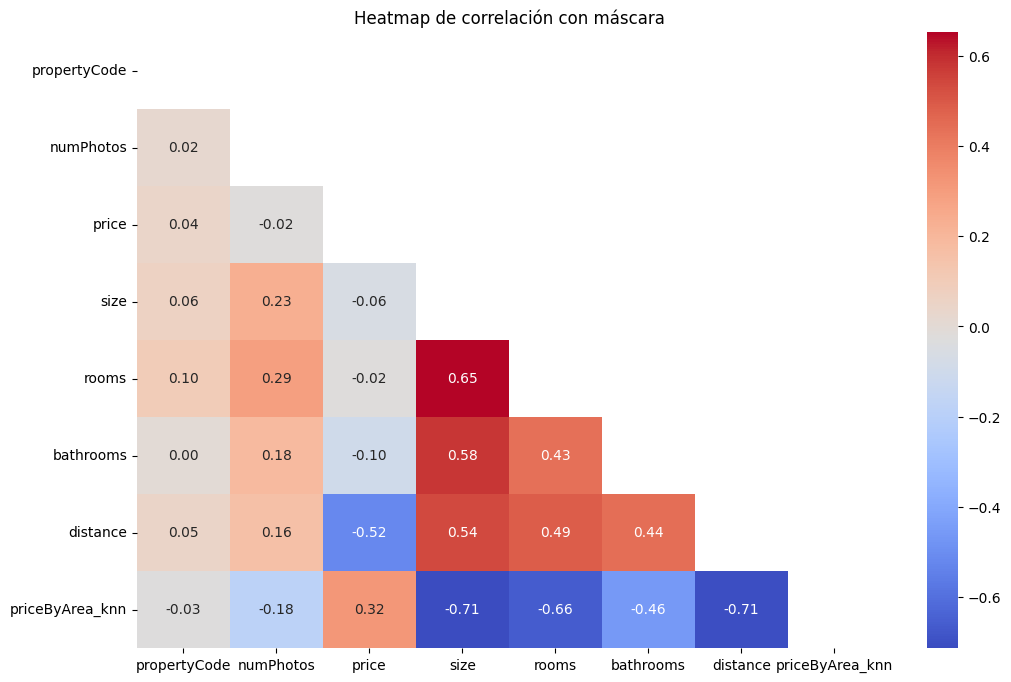

In [95]:
# Calcular la matriz de correlación
correlation_matrix = df_num.corr()

# Crear una máscara para ocultar la mitad superior
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Crear el heatmap con la máscara
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Heatmap de correlación con máscara")
plt.show()

In [96]:
df.drop(columns=["priceByArea_knn","size"],inplace= True)

In [97]:
df.columns
df_representacion = df[['numPhotos', 'price', 'propertyType', 'operation', 'exterior', 'rooms',
       'bathrooms', 'showAddress', 'distance', 'hasVideo', 'status',
       'newDevelopment', 'hasPlan', 'has3DTour', 'has360',
       'hasStaging', 'superTopHighlight', 'topNewDevelopment', 'floor',
       'hasLift']]

In [98]:
df["price"].value_counts()

price
750.0    96
700.0    49
650.0    38
600.0    23
720.0    23
         ..
380.0     1
733.0     1
605.0     1
480.0     1
745.0     1
Name: count, Length: 63, dtype: int64

IndexError: index 18 is out of bounds for axis 0 with size 18

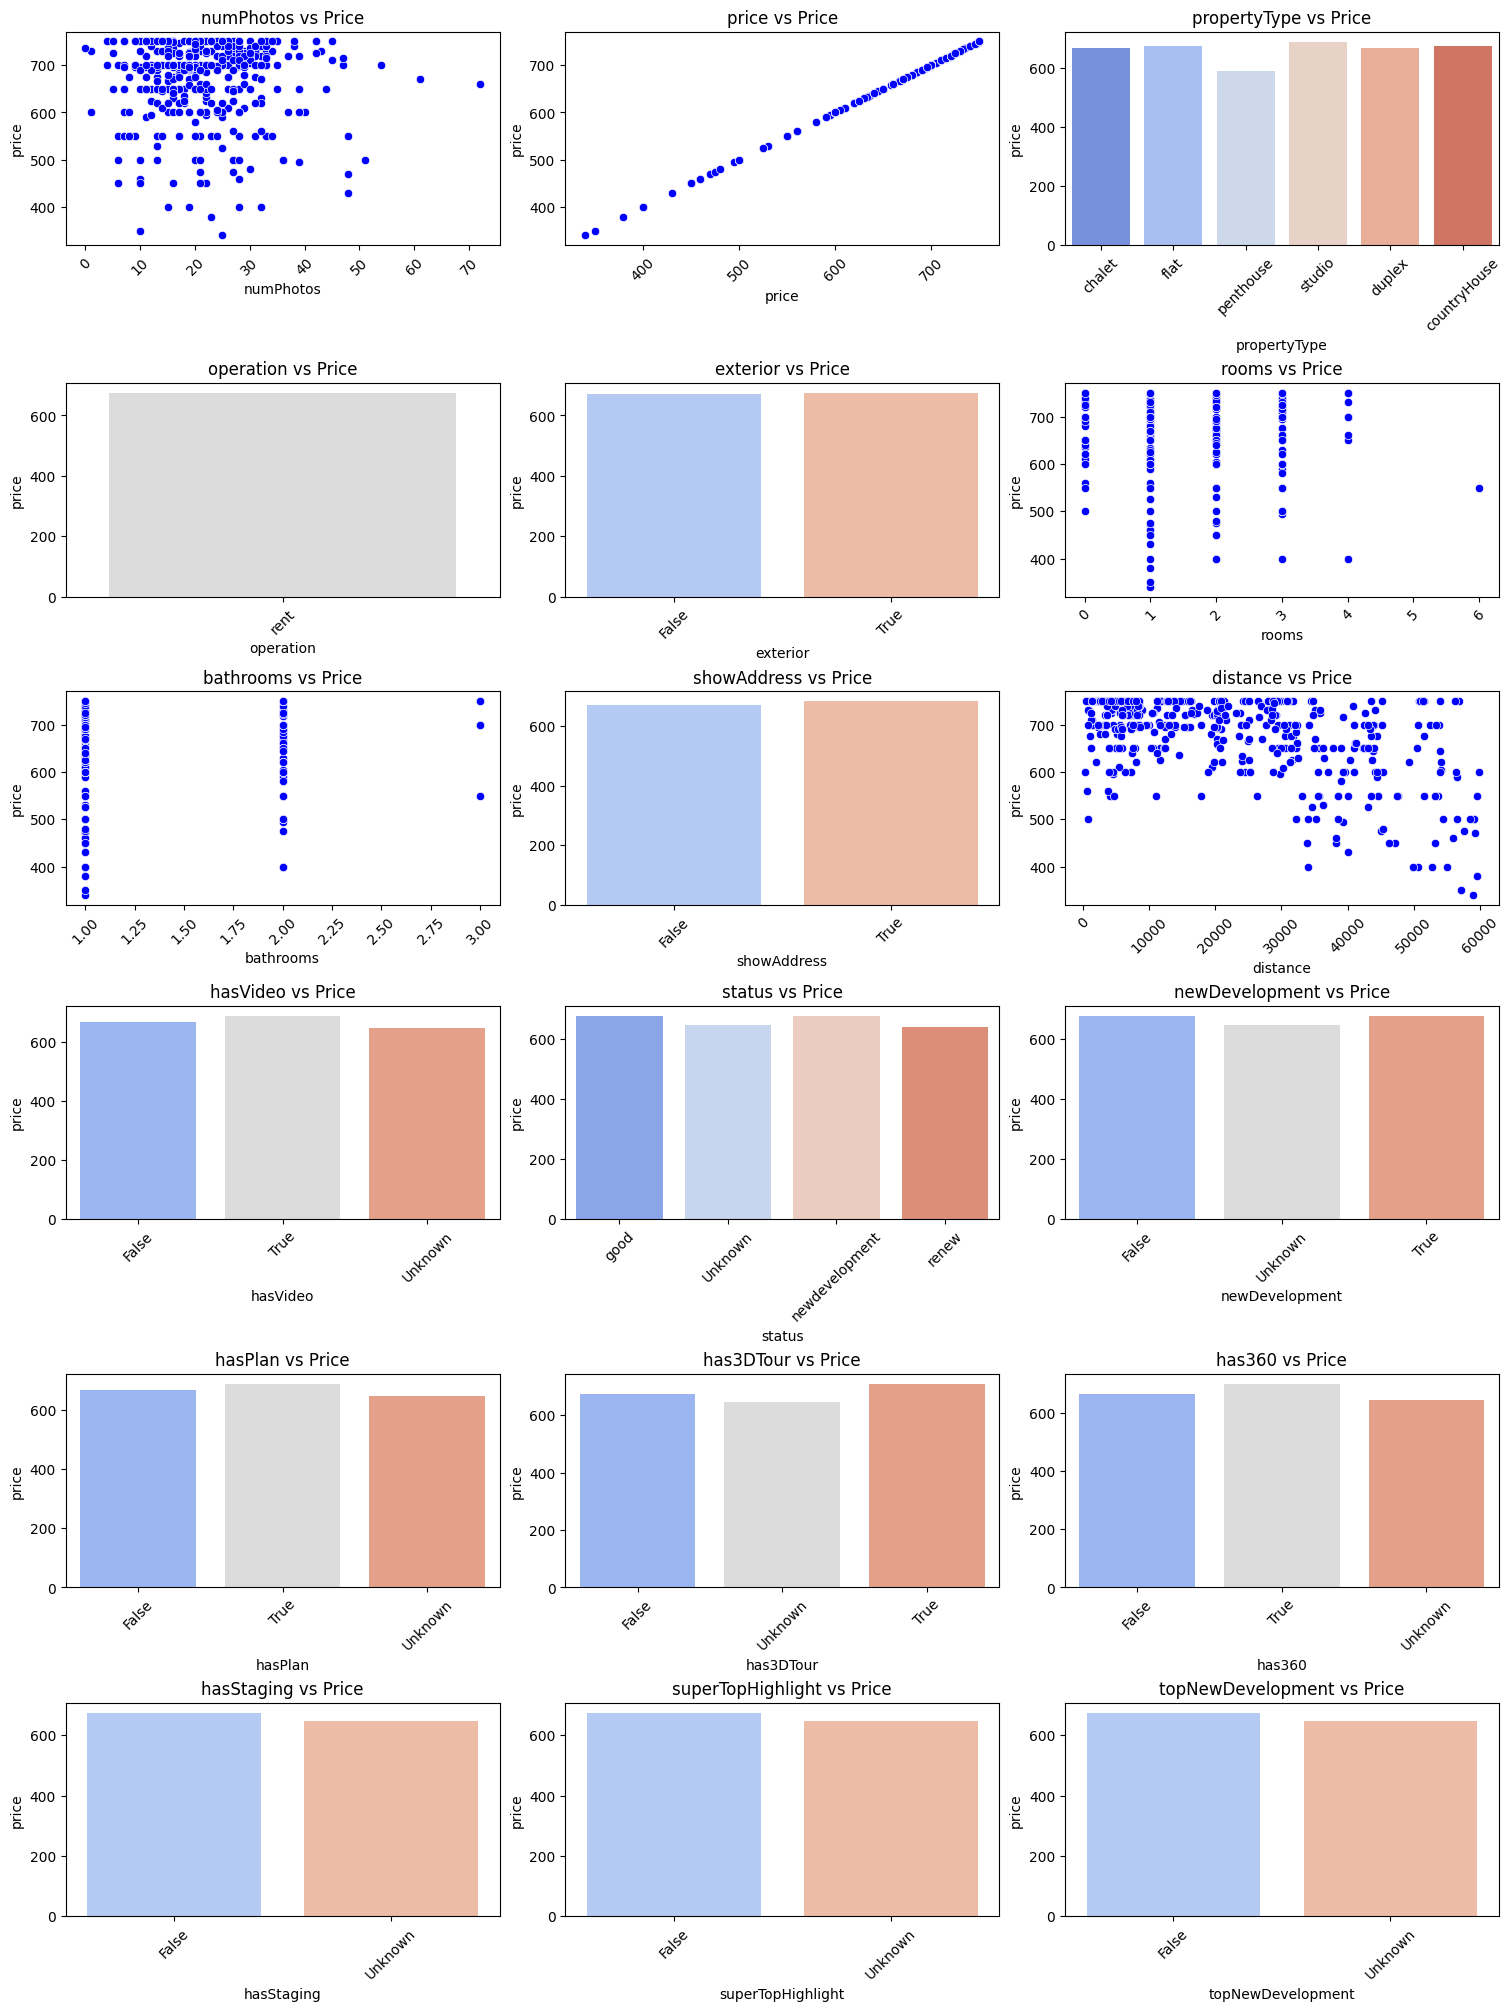

In [99]:

# Crear subplots
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 20), constrained_layout=True)
axes = axes.flatten()  # Aplanar los ejes para iterar fácilmente

for i, column in enumerate(df_representacion):
    ax = axes[i]
    if df_representacion[column].dtype == 'object' or df_representacion[column].dtype == 'bool':
        # Gráfico para variables categóricas
        sns.barplot(data=df_representacion, x=column, y='price', ax=ax, estimator='mean', ci=None, palette='coolwarm')
    else:
        # Gráfico para variables numéricas
        sns.scatterplot(data=df_representacion, x=column, y='price', ax=ax, color='b')
    
    ax.set_title(f'{column} vs Price')
    ax.tick_params(axis='x', rotation=45)

# Ajustar layout y eliminar subplots vacíos
for j in range(len(df_representacion), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Relación de Precio con Otras Columnas", fontsize=16, y=1.02)
plt.show()


In [ ]:
df.drop(columns = ["operation","superTopHighligt"],inplace = True)

KeyError: "['superTopHighligt'] not found in axis"

In [ ]:
df.to_csv("../Datos/df_nonulos_final.csv")